In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Extracting MNIST_data\train-images-idx3-ubyte.gz
Extracting MNIST_data\train-labels-idx1-ubyte.gz
Extracting MNIST_data\t10k-images-idx3-ubyte.gz
Extracting MNIST_data\t10k-labels-idx1-ubyte.gz


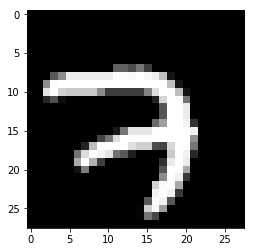

In [6]:
plt.imshow(mnist.train.images[0].reshape(28,28), cmap='gray')

In [7]:
print(mnist.train.labels[0])

7


In [8]:
def Inputs(dim, z_dim):
    x = tf.placeholder(tf.float32, shape=(None, dim))
    z = tf.placeholder(tf.float32, shape=(None, z_dim))
    return x, z

In [9]:
def Generator(z, reuse):
    with tf.variable_scope('Generator', reuse = not reuse):
        alpha = 0.01
        x = tf.layers.dense(z, 128, activation=None)
        bn = tf.maximum(alpha*x, x)
        x1 = tf.layers.dense(bn, 784, activation=None)
        out = tf.nn.tanh(x1)
        return out

In [10]:
def Discriminator(image, reuse):
    with tf.variable_scope('Discriminator', reuse = reuse):
        alpha = 0.01
        x = tf.layers.dense(image, 128, activation = None)
        bn1 = tf.maximum(x*alpha, x)
        logit = tf.layers.dense(bn1, 1, activation = None)
        out = tf.nn.sigmoid(logit)
        return out, logit

In [11]:
def Loss(x, z):
    
    fake_img = Generator(z, True)
    out_r, logit_r = Discriminator(x, reuse = False)
    out_f, logit_f = Discriminator(fake_img, reuse = True)
    
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logit_r, labels = tf.ones_like(logit_r)*0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logit_f, labels = tf.zeros_like(logit_f)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logit_f, labels = tf.ones_like(logit_f)))
    
    d_total_loss = d_loss_fake + d_loss
    
    return d_total_loss, g_loss

In [12]:
def Optimizer(d_loss, g_loss):
    
    var_list = tf.trainable_variables()
    g_vars = [var for var in var_list if var.name.startswith('Generator')]
    d_vars = [var for var in var_list if var.name.startswith('Discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(0.002, beta1=0.5).minimize(d_loss, var_list = d_vars)
        g_opt = tf.train.AdamOptimizer(0.002, beta1=0.5).minimize(g_loss, var_list = g_vars)
    return d_opt, g_opt

In [13]:
n_epochs = 51
batch_size = 100
z_dim = 100

Epoch:0  Discriminator:1.0343468189239502   Generator:1.052738904953003


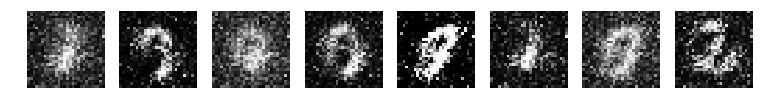

Epoch:10  Discriminator:1.2285635471343994   Generator:0.9896677136421204


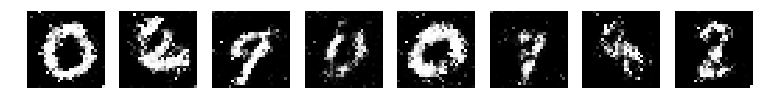

Epoch:20  Discriminator:1.2603578567504883   Generator:0.9005210995674133


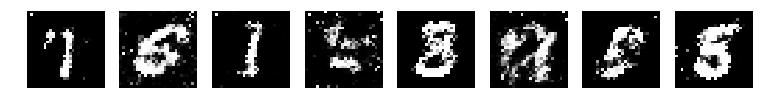

Epoch:30  Discriminator:1.2025363445281982   Generator:0.9976624250411987


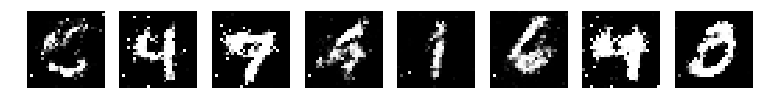

Epoch:40  Discriminator:1.1675245761871338   Generator:1.009567379951477


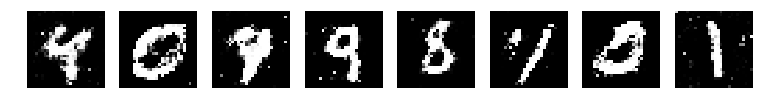

Epoch:50  Discriminator:1.1717486381530762   Generator:0.9855994582176208


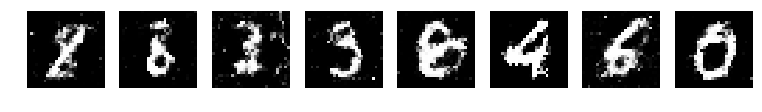

In [14]:
tf.reset_default_graph()
init = tf.global_variables_initializer()
x, z = Inputs(784, z_dim)
d_loss, g_loss = Loss(x, z)
d_opt, g_opt = Optimizer(d_loss, g_loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(n_epochs):
        for ii in range(mnist.train.num_examples//batch_size):

            batch = mnist.train.next_batch(batch_size)

            batch_images = batch[0].reshape(batch_size, 784)
            batch_images = batch_images*2 - 1

            batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

            _ = sess.run(d_opt, feed_dict = {x: batch_images, z: batch_z})
            _ = sess.run(g_opt, feed_dict = {x: batch_images, z: batch_z})

            d_loss_t = d_loss.eval({x: batch_images, z: batch_z})
            g_loss_t = g_loss.eval({x: batch_images, z: batch_z})
        
        if epoch % 10 == 0:
            print("Epoch:{0}  Discriminator:{1}   Generator:{2}".format(epoch, d_loss_t, g_loss_t))

            f, axis = plt.subplots(1, 8, figsize=(13, 8))
            batch_samples = np.random.uniform(-1, 1, size=(8, z_dim))
            gen_images = sess.run(Generator(z, False), feed_dict = {z:batch_samples})
            for i in range(8):
                axis[i].imshow(gen_images[i].reshape(28, 28), cmap='Greys_r')
                axis[i].axis('off')
            f.savefig('samples/epoch{0}.png'.format(epoch))
            plt.show()